In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler 

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
# 灰色预测模型
class GrayForecast():
    #初始化
    def __init__(self, data, datacolumn=None):
        if isinstance(data, pd.core.frame.DataFrame):
            self.data=data
            try:
                self.data.columns = ['数据']
            except:
                if not datacolumn:
                    raise Exception('您传入的dataframe不止一列')
                else:
                    self.data = pd.DataFrame(data[datacolumn])
                    self.data.columns=['数据']
        elif isinstance(data, pd.core.series.Series):
            self.data = pd.DataFrame(data, columns=['数据'])
        else:
            self.data = pd.DataFrame(data, columns=['数据'])
        self.forecast_list = self.data.copy()
        if datacolumn:
            self.datacolumn = datacolumn
        else:
            self.datacolumn = None
   
    #级比校验
    def level_check(self):
        # 数据级比校验
        n = len(self.data)
        lambda_k = np.zeros(n-1)
        for i in range(n-1):
            lambda_k[i] = self.data.ix[i]["数据"]/self.data.ix[i+1]["数据"]
            if lambda_k[i] < np.exp(-2/(n+1)) or lambda_k[i] > np.exp(2/(n+2)):
                flag = False
            else:
                flag = True
            self.lambda_k = lambda_k
            if not flag:
                print("级比校验失败，请对X(0)做平移变换")
                return False
            else:
                print("级比校验成功，请继续")
                return True

    #GM(1,1)建模
    def GM_11_build_model(self, forecast=5):
        if forecast > len(self.data):
            raise Exception('您的数据行不够')
        X_0 = np.array(self.forecast_list['数据'].tail(forecast))
        #       1-AGO
        X_1 = np.zeros(X_0.shape)
        for i in range(X_0.shape[0]):
            X_1[i] = np.sum(X_0[0:i+1])
        #       紧邻均值生成序列
        Z_1 = np.zeros(X_1.shape[0]-1)
        for i in range(1, X_1.shape[0]):
            Z_1[i-1] = -0.5*(X_1[i]+X_1[i-1])
        B = np.append(np.array(np.mat(Z_1).T), np.ones(Z_1.shape).reshape((Z_1.shape[0], 1)), axis=1)
        Yn = X_0[1:].reshape((X_0[1:].shape[0], 1))
        B = np.mat(B)
        Yn = np.mat(Yn)
        a_ = (B.T*B)**-1 * B.T * Yn
        a, b = np.array(a_.T)[0]
        X_ = np.zeros(X_0.shape[0])
        def f(k):
            return (X_0[0]-b/a)*(1-np.exp(a))*np.exp(-a*(k))
        self.forecast_list.loc[len(self.forecast_list)] = f(X_.shape[0])
      
    #预测
    def forecast(self, time=5, forecast_data_len=5):
        for i in range(time):
            self.GM_11_build_model(forecast=forecast_data_len)
      
    #打印日志
    def log(self):
        res = self.forecast_list.copy()
        if self.datacolumn:
            res.columns = [self.datacolumn]
        return res
    
    #重置
    def reset(self):
        self.forecast_list = self.data.copy()
      
    #作图
    def plot(self):
        self.forecast_list.plot()
        if self.datacolumn:
            plt.ylabel(self.datacolumn)
            plt.legend([self.datacolumn])

In [3]:
weather = pd.read_excel(r"E:/数据分析数据集/td/水果/天气.xls")
weather

,日期,最高气温,最低气温,天气,风向,风力,空气质量指数,空气质量
0,2019-12-01,4,-5,晴,西北风,2级,32,优
1,2019-12-02,4,-5,晴,西南风,2级,25,优
2,2019-12-03,7,-4,晴,西北风,2级,45,优
3,2019-12-04,8,-5,晴,西北风,2级,30,优
4,2019-12-05,2,-6,晴,东北风,2级,37,优
...,...,...,...,...,...,...,...,...
754,2021-12-24,-4,-10,晴,东北风,3级,27,优
755,2021-12-25,-4,-11,晴,西北风,3级,17,优
756,2021-12-26,-1,-8,晴,西北风,2级,28,优
757,2021-12-27,6,-8,晴,西北风,1级,56,良


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      759 non-null    datetime64[ns]
 1   最高气温    759 non-null    int64         
 2   最低气温    759 non-null    int64         
 3   天气      759 non-null    object        
 4   风向      759 non-null    object        
 5   风力      759 non-null    object        
 6   空气质量指数  759 non-null    int64         
 7   空气质量    759 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 47.6+ KB


In [5]:
jujube = pd.read_excel(r"E:/数据分析数据集/td/水果/水果.xlsx",sheet_name='冬枣')
jujube

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-28 00:00:00
1,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-27 00:00:00
2,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-26 00:00:00
3,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-24 00:00:00
4,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-25 00:00:00
...,...,...,...,...,...,...,...,...
465,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-19 00:00:00
466,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-17 00:00:00
467,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-20 00:00:00
468,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-18 00:00:00


In [6]:
jujube['发布日期'] = pd.DatetimeIndex(jujube['发布日期'])

In [7]:
jujube

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-28
1,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-27
2,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-26
3,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-24
4,冬枣,2.0,6.0,4.00,NaN,NaN,斤,2021-12-25
...,...,...,...,...,...,...,...,...
465,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-19
466,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-17
467,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-20
468,冬枣,1.5,4.0,2.75,其他类,NaN,斤,2019-11-18


In [8]:
peach = pd.read_excel(r"E:/数据分析数据集/td/水果/水果.xlsx",sheet_name='水蜜桃')
peach

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-25 00:00:00
1,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-24 00:00:00
2,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-22 00:00:00
3,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-21 00:00:00
4,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-23 00:00:00
...,...,...,...,...,...,...,...,...
334,水蜜桃,12.0,14.0,13.00,桃李杏类,NaN,斤,2020-03-12 00:00:00
335,水蜜桃,12.0,15.0,13.50,桃李杏类,NaN,斤,2020-03-11 00:00:00
336,水蜜桃,12.0,15.0,13.50,桃李杏类,NaN,斤,2020-03-10 00:00:00
337,水蜜桃,4.0,8.0,6.00,桃李杏类,NaN,斤,2019-11-17 00:00:00


In [9]:
peach['发布日期'] = pd.DatetimeIndex(peach['发布日期'])
peach

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-25
1,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-24
2,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-22
3,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-21
4,水蜜桃,4.0,4.5,4.25,NaN,NaN,斤,2021-10-23
...,...,...,...,...,...,...,...,...
334,水蜜桃,12.0,14.0,13.00,桃李杏类,NaN,斤,2020-03-12
335,水蜜桃,12.0,15.0,13.50,桃李杏类,NaN,斤,2020-03-11
336,水蜜桃,12.0,15.0,13.50,桃李杏类,NaN,斤,2020-03-10
337,水蜜桃,4.0,8.0,6.00,桃李杏类,NaN,斤,2019-11-17


In [10]:
melon = pd.read_excel(r"E:/数据分析数据集/td/水果/水果.xlsx",sheet_name='哈密瓜')
melon

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-15 00:00:00
1,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-12 00:00:00
2,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-14 00:00:00
3,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-13 00:00:00
4,哈密瓜,1.5,1.6,1.55,NaN,NaN,斤,2021-08-08 00:00:00
...,...,...,...,...,...,...,...,...
336,哈密瓜,1.8,2.5,2.15,甜瓜类,NaN,斤,2019-11-20 00:00:00
337,哈密瓜,1.8,2.5,2.15,甜瓜类,NaN,斤,2019-11-19 00:00:00
338,哈密瓜,1.6,2.0,1.80,甜瓜类,NaN,斤,2019-11-17 00:00:00
339,哈密瓜,1.8,2.5,2.15,甜瓜类,NaN,斤,2019-11-18 00:00:00


In [11]:
melon['发布日期'] = pd.DatetimeIndex(melon['发布日期'])
melon

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-15
1,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-12
2,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-14
3,哈密瓜,1.3,1.5,1.40,NaN,NaN,斤,2021-08-13
4,哈密瓜,1.5,1.6,1.55,NaN,NaN,斤,2021-08-08
...,...,...,...,...,...,...,...,...
336,哈密瓜,1.8,2.5,2.15,甜瓜类,NaN,斤,2019-11-20
337,哈密瓜,1.8,2.5,2.15,甜瓜类,NaN,斤,2019-11-19
338,哈密瓜,1.6,2.0,1.80,甜瓜类,NaN,斤,2019-11-17
339,哈密瓜,1.8,2.5,2.15,甜瓜类,NaN,斤,2019-11-18


In [12]:
berry = pd.read_excel(r"E:/数据分析数据集/td/水果/水果.xlsx",sheet_name='甜宝(奶油)草莓')
berry

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-26 00:00:00
1,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-25 00:00:00
2,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-28 00:00:00
3,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-21 00:00:00
4,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-22 00:00:00
...,...,...,...,...,...,...,...,...
375,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-21 00:00:00
376,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-19 00:00:00
377,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-17 00:00:00
378,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-18 00:00:00


In [13]:
berry['发布日期'] = pd.DatetimeIndex(berry['发布日期'])
berry

,品名,最低价,最高价,平均价,规格,产地,单位,发布日期
0,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-26
1,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-25
2,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-28
3,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-21
4,甜宝(奶油)草莓,4.0,7.0,5.5,其他类,NaN,斤,2021-05-22
...,...,...,...,...,...,...,...,...
375,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-21
376,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-19
377,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-17
378,甜宝(奶油)草莓,8.0,10.0,9.0,其他类,NaN,斤,2019-11-18


In [14]:
jujube = pd.merge(weather,jujube.rename(columns={'发布日期':'日期'})[['日期','平均价']],on='日期',sort=True)
peach = pd.merge(weather,peach.rename(columns={'发布日期':'日期'})[['日期','平均价']],on='日期',sort=True)
melon = pd.merge(weather,melon.rename(columns={'发布日期':'日期'})[['日期','平均价']],on='日期',sort=True)
berry = pd.merge(weather,berry.rename(columns={'发布日期':'日期'})[['日期','平均价']],on='日期',sort=True)

In [15]:
jujube

,日期,最高气温,最低气温,天气,风向,风力,空气质量指数,空气质量,平均价
0,2019-12-01,4,-5,晴,西北风,2级,32,优,2.75
1,2019-12-02,4,-5,晴,西南风,2级,25,优,2.75
2,2019-12-03,7,-4,晴,西北风,2级,45,优,2.75
3,2019-12-04,8,-5,晴,西北风,2级,30,优,2.75
4,2019-12-05,2,-6,晴,东北风,2级,37,优,2.75
...,...,...,...,...,...,...,...,...,...
450,2021-12-24,-4,-10,晴,东北风,3级,27,优,4.00
451,2021-12-25,-4,-11,晴,西北风,3级,17,优,4.00
452,2021-12-26,-1,-8,晴,西北风,2级,28,优,4.00
453,2021-12-27,6,-8,晴,西北风,1级,56,良,4.00


In [16]:
peach

,日期,最高气温,最低气温,天气,风向,风力,空气质量指数,空气质量,平均价
0,2020-03-10,11,-4,晴,西北风,3级,33,优,13.50
1,2020-03-11,16,1,晴,东北风,1级,44,优,13.50
2,2020-03-12,14,-2,多云,东北风,3级,43,优,13.00
3,2020-03-13,12,-1,晴,西北风,3级,30,优,13.00
4,2020-03-14,16,3,晴,西北风,3级,34,优,13.00
...,...,...,...,...,...,...,...,...,...
332,2021-10-21,19,5,晴,西北风,2级,40,优,4.25
333,2021-10-22,18,2,晴,西北风,2级,32,优,4.25
334,2021-10-23,18,3,晴,西南风,1级,55,良,4.25
335,2021-10-24,17,4,多云,西南风,1级,109,轻度污染,4.25


In [17]:
melon

,日期,最高气温,最低气温,天气,风向,风力,空气质量指数,空气质量,平均价
0,2019-12-01,4,-5,晴,西北风,2级,32,优,2.00
1,2019-12-02,4,-5,晴,西南风,2级,25,优,2.50
2,2019-12-03,7,-4,晴,西北风,2级,45,优,3.25
3,2019-12-04,8,-5,晴,西北风,2级,30,优,3.25
4,2019-12-05,2,-6,晴,东北风,2级,37,优,3.25
...,...,...,...,...,...,...,...,...,...
321,2021-08-08,31,23,阴~雷阵雨,南风,2级,72,良,1.55
322,2021-08-12,29,22,阴~雷阵雨,东南风,2级,39,优,1.40
323,2021-08-13,29,22,阴~雷阵雨,东南风,2级,36,优,1.40
324,2021-08-14,28,22,阴~雷阵雨,东南风,2级,37,优,1.40


In [18]:
berry

,日期,最高气温,最低气温,天气,风向,风力,空气质量指数,空气质量,平均价
0,2019-12-01,4,-5,晴,西北风,2级,32,优,20.5
1,2019-12-02,4,-5,晴,西南风,2级,25,优,21.0
2,2019-12-03,7,-4,晴,西北风,2级,45,优,21.0
3,2019-12-04,8,-5,晴,西北风,2级,30,优,22.0
4,2019-12-05,2,-6,晴,东北风,2级,37,优,21.5
...,...,...,...,...,...,...,...,...,...
360,2021-05-24,24,13,多云,西北风,3级,57,良,5.5
361,2021-05-25,28,15,多云,西南风,微风,63,良,5.5
362,2021-05-26,28,13,阴~晴,北风,2级,57,良,5.5
363,2021-05-27,28,16,雷阵雨~多云,西北风,3级,47,优,5.5


In [19]:
def correation(fruit):
    fruit[['天气','风向','风力','空气质量']] = OrdinalEncoder().fit_transform(fruit[['天气','风向','风力','空气质量']])
    fruit.insert(1,'月份',fruit['日期'].apply(lambda x:str(x).split('-')[1]))
    fruit['月份'] = fruit['月份'].astype('int')
    return fruit.corr()

In [20]:
correation_jujube = correation(jujube)

In [21]:
correation_peach = correation(peach)

In [22]:
correation_melon = correation(melon)

In [23]:
correation_berry = correation(berry)

In [24]:
writer = pd.ExcelWriter('E:/数据分析数据集/td/水果/correation.xlsx')
for i in ['correation_jujube','correation_peach','correation_melon','correation_berry']:
       eval(i).to_excel(excel_writer=writer,sheet_name=i,index=True)
writer.save()

In [25]:
def importance_feature(fruit):
    X = fruit[['最高气温','最低气温','天气','风向','风力','空气质量指数','空气质量']]
    X_ = StandardScaler().fit_transform(X)
    y = fruit['平均价']
    lasso = Lasso(alpha=0.6).fit(X_,y)
    return pd.DataFrame(([*zip(X.columns,np.abs(lasso.coef_))])).sort_values(1,ascending=False).iloc[0,:][0]

In [26]:
jujube_feature = importance_feature(jujube)
jujube_feature

'最低气温'

In [27]:
peach_feature  = importance_feature(peach)
peach_feature

'风力'

In [28]:
melon_feature = importance_feature(melon)
melon_feature

'最高气温'

In [29]:
berry_feature = importance_feature(berry)
berry_feature

'最低气温'

In [36]:
def predict(fruit):
    prediction = GrayForecast(fruit[['日期','平均价']], '平均价')
    prediction.forecast(30)
    prediction.log()
    return prediction.log()[-30:],prediction.plot()

(           平均价
 455   4.571429
 456   4.601381
 457   4.919620
 458   5.253758
 459   5.463822
 460   5.827499
 461   6.139359
 462   6.468073
 463   6.849623
 464   7.216091
 465   7.619692
 466   8.044606
 467   8.483164
 468   8.953603
 469   9.444361
 470   9.960846
 471  10.506521
 472  11.078477
 473  11.681292
 474  12.315406
 475  12.981826
 476  13.683232
 477  14.420536
 478  15.195771
 479  16.010934
 480  16.867709
 481  17.768329
 482  18.714862
 483  19.709508
 484  20.754666,
 None)

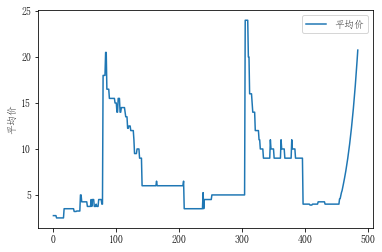

In [37]:
predict(jujube)

In [31]:
predict_jujube = predict(jujube).reset_index(drop=True)

In [32]:
predict_peach = predict(peach).reset_index(drop=True)

In [33]:
predict_melon = predict(melon).reset_index(drop=True)

In [34]:
predict_berry = predict(berry).reset_index(drop=True)

In [35]:
writer = pd.ExcelWriter('E:/数据分析数据集/td/水果/predict30.xlsx')
for i in ['predict_jujube','predict_peach','predict_melon','predict_berry']:
       eval(i).to_excel(excel_writer=writer,sheet_name=i,index=False)
writer.save()
writer.close()

E:\Program Files\Anaconda\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
